# Training for Fraud Detection 
## Part 1: Cost Sensitive Thresholding

In [5]:
import pandas as pd
import numpy as np
from scipy import interp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns



%matplotlib inline

Prepare training and test (holdout) datasets...

In [7]:
dat = pd.read_csv('./../data/explored.csv')
final_cols = ['merchantidentifier','first_transaction_amount','time_to_first_txn','loc_hmg_coeff','org_fraud_prevalence', 'is_txn_amt_fraud_prevalence_high','is_fraud']
dat_sub = dat[final_cols]
#convert loc_hmg_coeff into a categorical so that the trees traverse each similarity category
dat_sub = pd.get_dummies(dat_sub, columns=['loc_hmg_coeff'])
dat_sub.sample(3)

,merchantidentifier,first_transaction_amount,time_to_first_txn,org_fraud_prevalence,is_txn_amt_fraud_prevalence_high,is_fraud,loc_hmg_coeff_0.25,loc_hmg_coeff_0.5,loc_hmg_coeff_0.75,loc_hmg_coeff_1.0
57769,39857491,85.0,70,0.024076,0,0,0.0,1.0,0.0,0.0
53242,38090569,5.0,20,0.013249,0,0,0.0,0.0,0.0,1.0
75404,43824349,163.5,262,0.025276,0,0,0.0,0.0,0.0,1.0


In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dat_sub[['first_transaction_amount','time_to_first_txn','loc_hmg_coeff_0.25','loc_hmg_coeff_0.5','loc_hmg_coeff_0.75','loc_hmg_coeff_1.0','org_fraud_prevalence','is_txn_amt_fraud_prevalence_high']],
                                                dat_sub[['is_fraud']], train_size=0.75)

In [9]:
# Xtrain.to_csv('./../data/xtrain.csv', index=False)
# ytrain.to_csv('./../data/ytrain.csv', index=False)
# Xtest.to_csv('./../data/xtest.csv', index=False)
# ytest.to_csv('./../data/ytest.csv', index=False)

On the first run, I'm going to use an *ensembling walk - Random Forest* approach to traverse this data randomly. Since we weren't able to build a very good parametric model, I prefer to traverse the dataset this way and let the algorithm learn the important features, and figure out the best interactions that mzimize its information gain.  

First, let's get an idea of the optimal number of trees to build for this RF walk. It might be overkill to run a grid search with many parameters at this point. 

In [30]:
scores=[]

for val in range(1, 500, 20):
    rf_thresh1 = RandomForestClassifier(n_estimators=val, n_jobs=6)
    validated = cross_val_score(rf_thresh1, Xtrain, np.array(ytrain).ravel(), cv=6, scoring='f1')
    scores.append(validated)

We run a random forest **not** accounting for the class imbalance on the first run because we want to give our decision thresholding a fair chance at maximizing precision/recall. We'll use the *F1 score* which is a harmonic balance of the classifier's precision and recall performance:  

$F1 = 2* P*R/(P+R)$

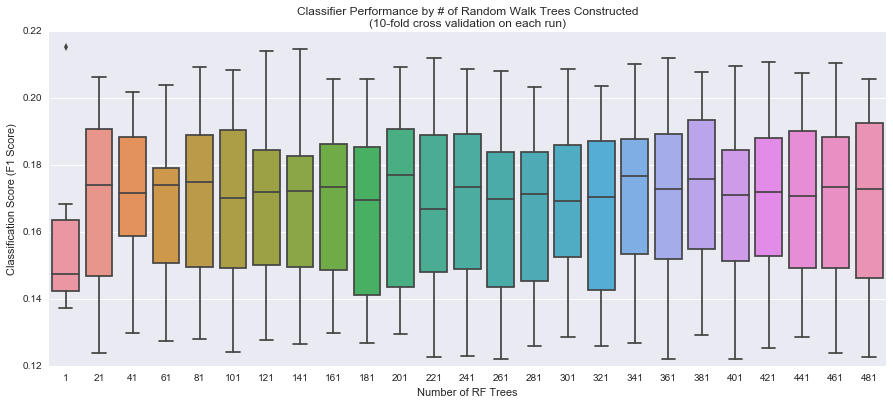

In [32]:
plt.figure(figsize=(15,6))
sns.boxplot(y=scores, x=range(1, 500, 20))
plt.xlabel('Number of RF Trees')
plt.ylabel('Classification Score (F1 Score)')
plt.title('Classifier Performance by # of Random Walk Trees Constructed\n(10-fold cross validation on each run)')

We see above that around **30-60 trees** seems to do the best job of capturing the highest median variation in the classifier's performance (F1 score).  

How well has the classifier done on an imbalanced dataset? Testing against the holdout set (Out of sample score)

In [10]:
clf1 = RandomForestClassifier(n_estimators=30)
clf1.fit(Xtrain, np.array(ytrain).ravel())

ypred = clf1.predict(Xtest)

print(confusion_matrix(ytest, ypred, labels=[1,0]))

[[  111   850]
 [  167 31594]]


In [11]:
print(classification_report(ytest, ypred, labels=[1,0], target_names=['fraud','not fraud']))

             precision    recall  f1-score   support

      fraud       0.40      0.12      0.18       961
  not fraud       0.97      0.99      0.98     31761

avg / total       0.96      0.97      0.96     32722



**While it did very well predicting the *not fraud* class, the classifier managed to identify 12% (*sensitivity*) of _fraudulent_ merchants in the dataset, with a *precision* of 40%.** 

### Baseline Validation with Decision Threshold at 50% 

How does the *Sensitivity* compare to the *Fallout* when we let the decision threshold remain at 50%? For our business case:  

* Sensitivity = True Positive Rate = $TP/(TP+FN)$ = % of actual fraudulent merchants in dataset identified.  
* Fallout = False Positive Rate = $FP/(FP+TN)$ = % of genuine merchants incorrectly classified as fraudulent.


In [14]:
def plot_ROC_PR(Xtrain, ytrain, k, rf_estimators, class_subsampling=None, cutoff=0.5):
    """
    Plot the ROC curve and AUC metric for given dataset, along with k-fold cross validation.
    Use a Random Forest classifier with ideal number of estimators pre-determined
    """
    cv = StratifiedKFold(np.array(ytrain).ravel(), n_folds=k) #preserves class %
    clf_rf = RandomForestClassifier(n_estimators=rf_estimators, verbose=0, criterion='gini', n_jobs=-1, class_weight=class_subsampling) 
    #clf_LR = LogisticRegression(n_jobs=-1, class_weight=class_subsampling)
    
    #plt.figure(figsize=(15,7))
    (fig, (ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(15,10))
    for i, (train, cval) in enumerate(cv):
        clf_rf.fit(Xtrain.iloc[train], np.array(ytrain.iloc[train]).ravel())
        #clf_LR.fit(Xtrain.iloc[train], np.array(ytrain.iloc[train]).ravel())

        probas_ = clf_rf.predict_proba(Xtrain.iloc[cval])
        #probas_ = clf_LR.predict_proba(Xtrain.iloc[cval])

        ypred = (probas_[:,1] > cutoff).astype(int)
        
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(ytrain.iloc[cval], probas_[:, 1], pos_label=1)
        precision, recall, thresholds = precision_recall_curve(ytrain.iloc[cval], probas_[:,1], pos_label=1) #sample_weight=np.where(ytrain.iloc[train]==1, 1.0, 30.0).ravel())
        f1 = f1_score(ytrain.iloc[cval], ypred, pos_label=1)

        #mean_tpr += interp(mean_fpr, fpr, tpr)
        #mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        ax2.plot(recall, precision, lw=1, label='ROC fold %d (F1 = %0.2f)' % (i, f1))
        #plt.plot(fpr, thresholds, lw=2, label='Decision Threshold at fold %d (%f)' % (i, np.mean(thresholds)))
    
    ax1.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Chance')
    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate\n(% of Genuine Merchants Misclassified for Fraud)')
    ax1.set_ylabel('True Positive Rate\n(% of All Fraudulent Merchants Caught from Dataset)')
    ax1.set_title('Receiver Operating Characteristic\nLogistic Regression (Decision Threshold = {:02.1f})'.format(cutoff))
    ax1.legend(loc="lower right")
    
    #ax2.set_xlim([-0.05, 1.05])
    #ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('Sensitivity\n(% of All Fraudulent Merchants Caught from Dataset)')
    ax2.set_ylabel('Precision\n(% Fraudulent Merchants Correctly Identified)')
    ax2.set_title('Precision-Recall Curve\nRandom Forests (Decision Threshold = {:02.1f})'.format(cutoff))
    ax2.legend(loc="lower right")
    
    plt.tight_layout()


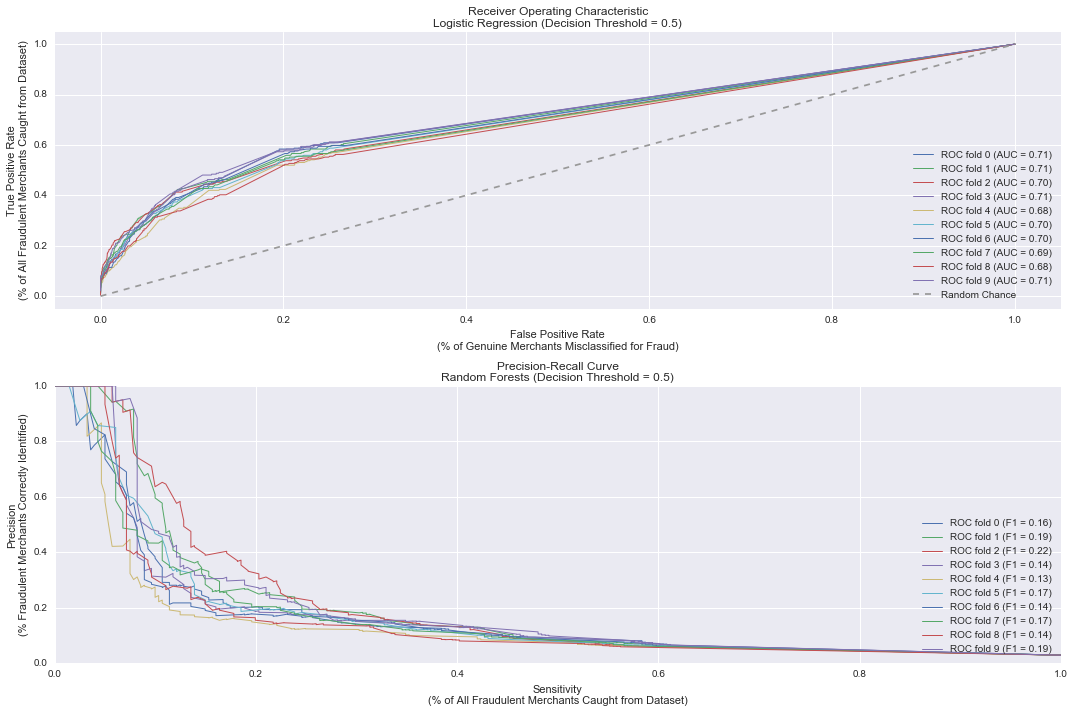

In [16]:
plot_ROC_PR(Xtrain, ytrain, 10, 30, None, 0.5)

In [106]:
clf2 = LogisticRegression()
clf2.fit(Xtrain, np.array(ytrain).ravel())

ypred = clf2.predict(Xtest)

print(confusion_matrix(ytest, ypred, labels=[1,0]))

[[   50   872]
 [   28 31772]]


In [107]:
print(classification_report(ytest, ypred, labels=[1,0], target_names=['fraud','not fraud']))

             precision    recall  f1-score   support

      fraud       0.64      0.05      0.10       922
  not fraud       0.97      1.00      0.99     31800

avg / total       0.96      0.97      0.96     32722



The optimal Area Under the Curve achieved by this classifier is 0.69, which suggests that it's performing better than random guesses about fraudulent merchants. Furthermore, the Precision-Recall curve suggests an optimal balance between the two is around 0.19, that is: If the desire is to be more certain about fraudulent merchants, then we compromise on finding out other frudulent merchants in the dataset, whereas if the desire is to catch as many fraudulent merchants as possible, then we run the risk of mis-abelling more genuine merchants as fraudulent as we attempt to catch more fraudulent merchants. 
At 19% Precision, we catch about 19% of actual fraudulent merchants in the dataset. 

Can Decision Thresholding improve this?

### Tuning the Decision Threshold

Can we improve the classifier's Precision and Sensitivity on the *fraud* class by tuning our decision threshold? Intuitively, on account of the severe imbalance of the fraud class, it seems that a decision threshold of < 0.5 might make our classifier more sensitive to fraudulent merchants, at the expense of misclassifying some more genuine merchants.  

For the business case, let's presume that it is more important to **improve sensitivity** to identify as many latent cases of fraud in the data as is possible. If a higher level of accuracy in identifying fraudulent merchants is desires (perhaps so as not to interfere with customer experience) then we'd instead focus on the *precision* of our classifier. 

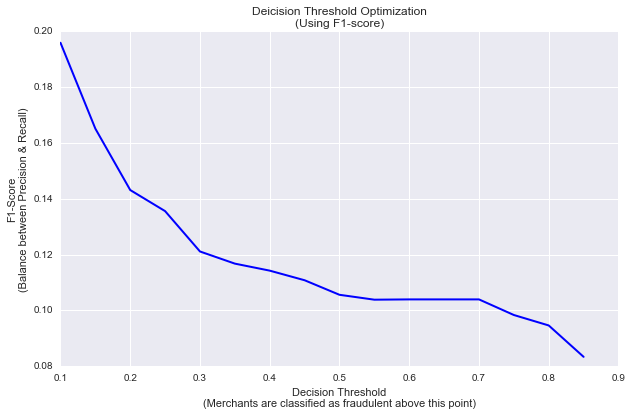

In [39]:
scores = []
cutoff_val=[]
#clf2 = RandomForestClassifier(n_estimators=30, class_weight=None)
clf3 = LogisticRegression()
#clf2.fit(Xtrain, np.array(ytrain).ravel())
clf3.fit(Xtrain, np.array(ytrain).ravel())
for cutoff in np.arange(0.1,0.9,0.05):
    ypred = (clf3.predict_proba(Xtest)[:,1] >= cutoff).astype(int)
    cutoff_val.append(cutoff)
    scores.append(f1_score(ytest, ypred))

plt.figure(figsize=(10,6))
plt.plot(cutoff_val,scores, 'b-', linewidth=2)
plt.xlabel('Decision Threshold\n(Merchants are classified as fraudulent above this point)')
plt.ylabel('F1-Score\n(Balance between Precision & Recall)')
plt.title('Deicision Threshold Optimization\n(Using F1-score)')

As suspected, we see that a Decision Threshold in the area of **0.25 to 0.3** gives us the best harmonic balance between the Precision and Recall of the classifier. Let's modify our prediction on this new decision threshold and see how our curves change...

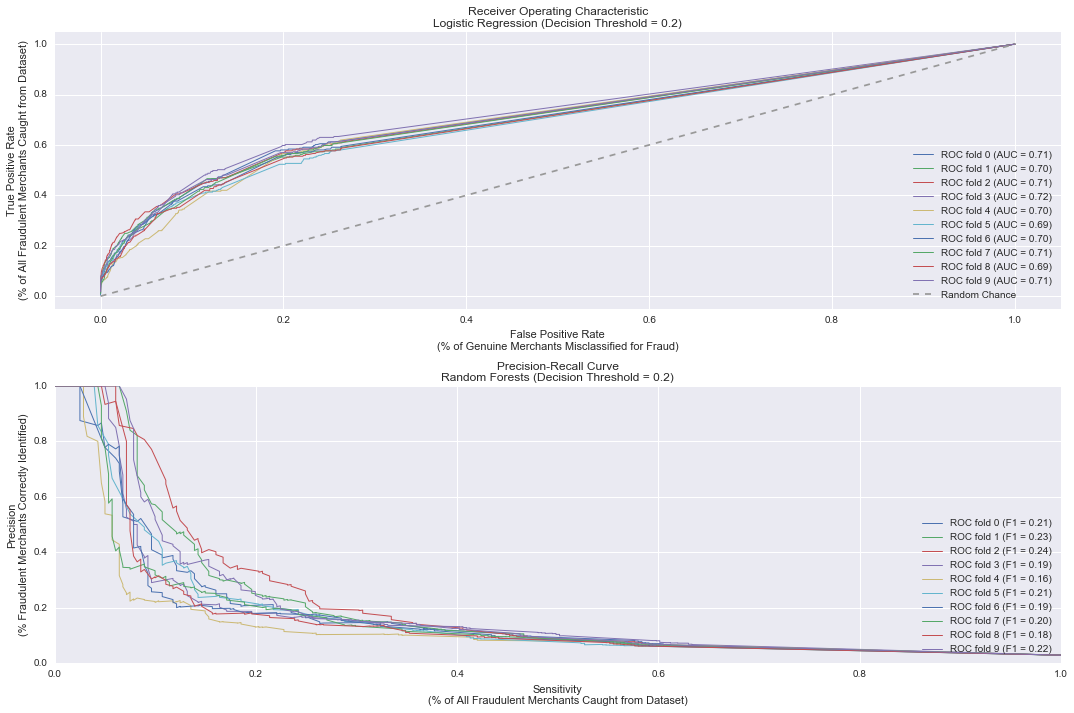

In [19]:
plot_ROC_PR(Xtrain, ytrain, 10, 30, None, 0.25) #DT=0.25


Reducing the Decision Threshold has improved our F1 score to over 23% , however it hasn't greatly changed the AUC suggesting that a more robust classifier needs to be built.

In [117]:
# clf3 = LogisticRegression()
# clf3.fit(Xtrain, np.array(ytrain).ravel())

# ypred = (clf3.predict_proba(Xtest)[:,1] > 0.1).astype(int)

# print(confusion_matrix(ytest, ypred, labels=[1,0]))

[[   89   833]
 [  159 31641]]


In [118]:
# print(classification_report(ytest, ypred, labels=[1,0], target_names=['fraud','not fraud']))

             precision    recall  f1-score   support

      fraud       0.36      0.10      0.15       922
  not fraud       0.97      0.99      0.98     31800

avg / total       0.96      0.97      0.96     32722



Finally, how do our Out of Sample metrics with a DT of 0.25 compare against a DT of 0.5?

In [40]:
clf4 = RandomForestClassifier(n_estimators=30)
clf4.fit(Xtrain, np.array(ytrain).ravel())

ypred = (clf4.predict_proba(Xtest)[:,1] >= 0.25).astype(int)
print(confusion_matrix(ytest, ypred, labels=[1,0]))


[[  213   748]
 [  789 30972]]


In [41]:
print(classification_report(ytest, ypred, labels=[1,0], target_names=['Fraud','Not Fraud']))


             precision    recall  f1-score   support

      Fraud       0.21      0.22      0.22       961
  Not Fraud       0.98      0.98      0.98     31761

avg / total       0.95      0.95      0.95     32722



As expected, reducing the Decision Threshold has increased our coverage (sensitivity) from 12% to catching 22% of merchants in the dataset, but it has compromised the precision from 40% accuracy in identifying fraudulent merchants to around 22%. 

---

In [26]:
Xtrain.columns

Index([u'first_transaction_amount', u'time_to_first_txn',
       u'loc_hmg_coeff_0.25', u'loc_hmg_coeff_0.5', u'loc_hmg_coeff_0.75',
       u'loc_hmg_coeff_1.0', u'org_fraud_prevalence',
       u'is_txn_amt_fraud_prevalence_high'],
      dtype='object')

In [27]:
clf4.feature_importances_

array([ 0.44378983,  0.22638508,  0.00264138,  0.00274298,  0.00249669,
        0.00403381,  0.30282878,  0.01508144])

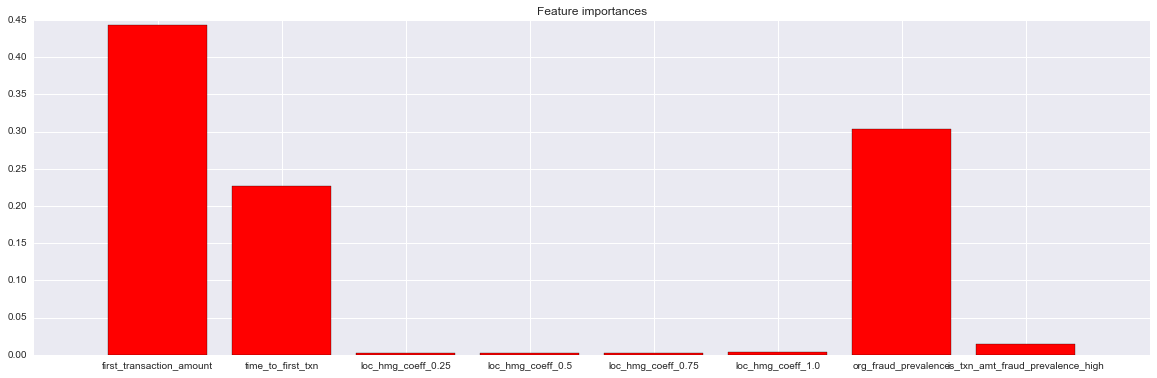

In [28]:
importances = clf4.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf4.estimators_],
             axis=0)

cols = zip(Xtrain.columns, importances)

#indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20,6))
plt.title("Feature importances")
plt.bar(range(Xtrain.shape[1]), importances,
       color="r", align="center")
plt.xticks(range(Xtrain.shape[1]), (Xtrain.columns))
plt.xlim([-1, Xtrain.shape[1]])
plt.show()